In [37]:
import os
import time

import pandas as pd 
import polars as pl 

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, min, max, count, countDistinct, date_format, when
from pyspark.sql.window import Window

import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
!pip show pyspark

Name: pyspark
Version: 3.5.7
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: C:\Users\lento\AppData\Local\Programs\Python\Python313\Lib\site-packages
Requires: py4j
Required-by: 


# **Spark 세션 생성**

- [스파크에 대해서](https://www.blog.data101.io/304)
- [스파크 설치하기](https://dslyh01.tistory.com/4)
- [스파크 UI 관찰하기](https://kadensungbincho.tistory.com/93)

In [4]:
# Spark 세션 만들기

# appName : 애플리케이션 이름
# master : 클러스터 URL, local[*]는 로컬 머신의 모든 코어 사용(CPU 코어 수에 따라 임의로 조정할 수 있음)
# spark.executor.memory : 각 실행자에 할당된 메모리 양 (클러스터에서 각 작업 프로세스(executer)가 쓸 수 있는 메모리 크기)
# spark.driver.memory : 드라이버 프로그램에 할당된 메모리 양 (내 컴퓨터 RAM에서 Spark 드라이버 프로세스가 쓸 수 있는 메모리 크기)
# spark.sql.shuffle.partitions : 셔플 작업에 사용되는 파티션 수
# spark.ui.showConsoleProgress : 콘솔에 진행 상황 표시 여부

start = time.time()
spark = SparkSession.builder \
    .appName("CheckSpark") \
    .master("local[*]") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "64") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()
end = time.time()

# Spark 세션이 제대로 생성되었는지 확인
print("Spark session created.", end - start, "seconds elapsed.")

Spark session created. 4.098841905593872 seconds elapsed.


In [5]:
# Spark 세션 출력
spark

In [6]:
# Spark 세션이 존재하는지 확인
spark_session = SparkSession.getActiveSession()

if spark_session is not None:
    print("Spark session is active.")

else:
    print("No active Spark session.")

Spark session is active.


# **데이터 컬럼명 의미**

## **Match / Aggregate 데이터 컬럼 설명**

| 컬럼명                 | 의미 / 설명                                       |
| ------------------- | --------------------------------------------- |
| date                | 경기가 시작된 날짜 및 시간                               |
| game_size           | 한 경기에 참여한 총 인원 수 (match 규모)                   |
| match_id            | 각 경기의 고유 식별자                                  |
| match_mode          | 경기 모드 (예: 1인칭 시점 FPP, 3인칭 시점 TPP 등)           |
| party_size          | 팀 당 인원 수 (예: 솔로면 1, 듀오면 2, 스쿼드면 4)            |
| player_assists      | 어시스트(도움) 횟수                                   |
| player_dbno         | knocked down (기절 상태로 만든) 횟수 — 적을 기절 상태로 만든 횟수 |
| player_dist_ride    | 차량으로 이동한 거리                                   |
| player_dist_walk    | 도보로 이동한 거리                                    |
| player_dmg          | 적에게 준 피해량 총합                                  |
| player_kills        | 처치(킬)한 적 수                                    |
| player_name         | 플레이어의 고유 게임 아이디                               |
| player_survive_time | 이 플레이어가 얼마나 오래 생존했는지 (초 또는 분 단위)              |
| team_id             | 이 플레이어가 속한 팀의 식별자                             |
| team_placement      | 경기 종료 시 팀의 순위 (예: 1등, 2등 등)                   |

## **Deaths / Kill 이벤트 데이터 컬럼 설명**

| 컬럼명               | 의미 / 설명                                  |
| ----------------- | ---------------------------------------- |
| killed_by         | 어떤 무기 또는 방식으로 죽었는지 (예: 무기 이름)            |
| killer_name       | 킬한 플레이어의 아이디                             |
| killer_placement  | 킬한 플레이어의 팀 최종 순위                         |
| killer_position_x | 킬이 발생한 시점의 killer의 X 좌표                  |
| killer_position_y | 킬이 발생한 시점의 killer의 Y 좌표                  |
| map               | 어느 맵에서 발생했는지 (예: Erangel, Miramar 등)     |
| match_id          | 이 사망 이벤트가 속한 경기 ID                       |
| time              | 경기가 시작된 후 경과한 시간 (킬이 발생한 시점, 초 또는 같은 단위) |
| victim_name       | 사망한(피해 본) 플레이어의 아이디                      |
| victim_placement  | 사망한 플레이어의 팀 최종 순위                        |
| victim_position_x | 사망 시점의 피해 플레이어의 X 좌표                     |
| victim_position_y | 사망 시점의 피해 플레이어의 Y 좌표                     |


# **데이터 불러오기**

In [7]:
# aggragate 폴더 내 모든 CSV 파일 불러오기
DATA_DIR = "./data/aggregate"

# 해당 디렉토리에서 csv 파일만 가져오기
csv_files = [
    os.path.join(DATA_DIR, f)
    for f in os.listdir(DATA_DIR)
    if f.endswith(".csv")
]

In [8]:
# 여러 CSV 파일을 한 번에 읽기
df = spark.read.csv(csv_files, header=True, inferSchema=True)

# **데이터 오버뷰**

In [9]:
# 데이터프레임의 스키마 출력
df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- game_size: integer (nullable = true)
 |-- match_id: string (nullable = true)
 |-- match_mode: string (nullable = true)
 |-- party_size: integer (nullable = true)
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: double (nullable = true)
 |-- player_dist_walk: double (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_survive_time: double (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- team_placement: integer (nullable = true)



In [10]:
# 데이터프레임의 첫 5개 행 출력
df.show(5)

+-------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+-----------+-------------------+-------+--------------+
|               date|game_size|            match_id|match_mode|party_size|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|
+-------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+-----------+-------------------+-------+--------------+
|2017-11-27 05:59:40|       37|2U4GBNA0YmnNZYkzj...|       tpp|         2|             0|          1|          2870.724|        1784.84778|       117|           1|   SnuffIes|            1106.32|      4|            18|
|2017-11-27 05:59:40|       37|2U4GBNA0YmnNZYkzj...|       tpp|         2|             0|          1|2938.4072300000003|1756

In [11]:
# 데이터프레임의 요약 통계 출력
# pandas : df.describe()
df.describe().show()

+-------+------------------+--------------------+----------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+----------------+-------------------+------------------+------------------+
|summary|         game_size|            match_id|match_mode|        party_size|     player_assists|       player_dbno|  player_dist_ride|  player_dist_walk|        player_dmg|      player_kills|     player_name|player_survive_time|           team_id|    team_placement|
+-------+------------------+--------------------+----------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+----------------+-------------------+------------------+------------------+
|  count|          67369231|            67369231|  67369231|          67369231|           67369231|          67369231|          67369231|          67369231|          67369231|          67369

In [12]:
# 레코드 수, 컬럼 수 확인
print(f"Number of records: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

# 컬럼명 확인
print("Columns:", df.columns)

Number of records: 67369231
Number of columns: 15
Columns: ['date', 'game_size', 'match_id', 'match_mode', 'party_size', 'player_assists', 'player_dbno', 'player_dist_ride', 'player_dist_walk', 'player_dmg', 'player_kills', 'player_name', 'player_survive_time', 'team_id', 'team_placement']


데이터의 크기는 `(67369231, 15)`

In [13]:
# 각 컬럼별 null 개수
df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]).show()

+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|date|game_size|match_id|match_mode|party_size|player_assists|player_dbno|player_dist_ride|player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|
+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|   0|        0|       0|         0|         0|             0|          0|               0|               0|         0|           0|      97653|                  0|      0|             0|
+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+



결측치는 `player_name`에서만 발생함.

# **데이터 오버뷰 한 눈에 보기**

In [14]:
def spark_df_report(df, num_rows: int = 5):
    print("=== DataFrame Overview ===")
    print(f"Row count: {df.count()}")
    print(f"Column count: {len(df.columns)}")
    print(f"Columns: {df.columns}")
    print()
    
    print("=== Schema ===")
    df.printSchema()
    print()
    
    print("=== Sample Data ===")
    df.show(n=num_rows, truncate=False)   # ✅ num_rows를 명시적으로 전달
    print()
    
    print("=== Descriptive Statistics ===")
    df.describe().show()
    print()
    
    print("=== Missing Values per Column ===")
    df.select([
        sum(col(c).isNull().cast("int")).alias(c)
        for c in df.columns
    ]).show()
    print()

In [15]:
spark_df_report(df)

=== DataFrame Overview ===
Row count: 67369231
Column count: 15
Columns: ['date', 'game_size', 'match_id', 'match_mode', 'party_size', 'player_assists', 'player_dbno', 'player_dist_ride', 'player_dist_walk', 'player_dmg', 'player_kills', 'player_name', 'player_survive_time', 'team_id', 'team_placement']

=== Schema ===
root
 |-- date: timestamp (nullable = true)
 |-- game_size: integer (nullable = true)
 |-- match_id: string (nullable = true)
 |-- match_mode: string (nullable = true)
 |-- party_size: integer (nullable = true)
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: double (nullable = true)
 |-- player_dist_walk: double (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_survive_time: double (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- team_placement: integer (nullable = true)


=== Sample

# **데이터 EDA**

## **게임 시점 분포**

In [16]:
df.groupBy("match_mode").count().orderBy("count", ascending=False).show()

+----------+--------+
|match_mode|   count|
+----------+--------+
|       tpp|67369231|
+----------+--------+



해당 데이터는 TPP (3인칭 시점) 게임으로 이루어진 매치들로만 구성되어 있음.

## **매칭 파티 분포**

In [17]:
df.groupBy("party_size").count().orderBy("count", ascending=False).show()

+----------+--------+
|party_size|   count|
+----------+--------+
|         4|31721314|
|         2|21608268|
|         1|14039649|
+----------+--------+



전체 중 약 3천만건 이상에서 Squad(4인 파티) 매칭을 참여함.

솔로 플레이는 약 1400만건으로, 사람들이 게임을 홀로 즐기는 사람도 어느 정도 있다는 것으로 확인.

## **데미지 총량 분포**

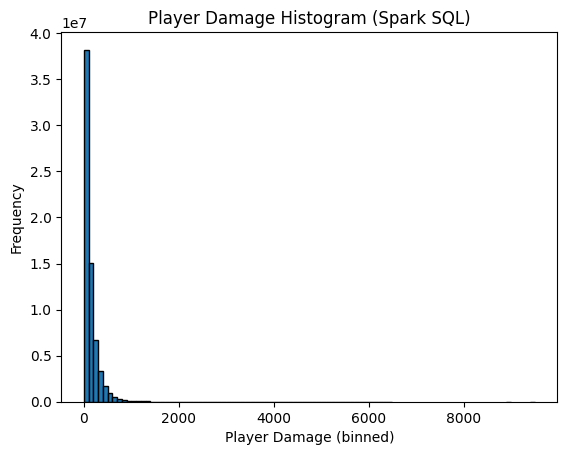

In [18]:
# bin 크기 설정 (예: 100 단위)
bin_size = 100
hist_df = (
    df.withColumn("bin", (col("player_dmg")/bin_size).cast("int")*bin_size)
      .groupBy("bin")
      .count()
      .orderBy("bin")
)

hist_pdf = hist_df.toPandas()

plt.bar(hist_pdf["bin"], hist_pdf["count"], width=bin_size, align="edge", edgecolor="black")
plt.xlabel("Player Damage (binned)")
plt.ylabel("Frequency")
plt.title("Player Damage Histogram (Spark SQL)")
plt.show()

전체적인 데미지 총량은 0~1500 구간에 많은 양이 분포함.

### **Q. Player Name이 결측치인 것은 데미지가 높아서 이름이 결측된 것인가?**

`player_dmg` 컬럼의 분포가 0~9408의 범위를 가짐.

PUBG에서 한 유저에 가하는 데미지는 차이가 있을 수 있지만, 유저의 HP를 100으로 두고 계산을 하기 떄문에 이상치로 판단될 여지가 있었음.

위의 내용을 근거하여, `player_name`이 결측이 된 이유가 해당 게임에서 부정행위(에임핵 등)을 사용해서 정지를 당한 유저가 해당 값에 결측이 된 것인지 확인하기 위함.

In [19]:
df_null = df.filter(col("player_name").isNull())
df_notnull = df.filter(col("player_name").isNotNull())

In [20]:
df_null.select(col("player_dmg")).describe().show()

+-------+------------------+
|summary|        player_dmg|
+-------+------------------+
|  count|             97653|
|   mean|119.68619499656948|
| stddev|183.77568855694227|
|    min|                 0|
|    max|              3908|
+-------+------------------+



In [21]:
df_notnull.select(col("player_dmg")).describe().show()

+-------+------------------+
|summary|        player_dmg|
+-------+------------------+
|  count|          67271578|
|   mean|123.95058684367416|
| stddev|169.47238443928399|
|    min|                 0|
|    max|              9408|
+-------+------------------+



요약본에서 바로 파악할 수 있듯, 밴을 당해 `player_name`이 결측이 생긴 것으로 판단할 수 없음을 확인할 수 있음.

### **Q. Player Name이 결측치가 발생한 시기는 언제인가?**

In [22]:
null_date_min = df_null.agg(min(col("date"))).collect()[0][0]
null_date_max = df_null.agg(max(col("date"))).collect()[0][0]
print(f"Null player_name date range: {null_date_min} to {null_date_max}")

Null player_name date range: 2017-10-20 17:04:48 to 2018-01-10 21:02:16


## **일별 게임 참여 유저 수**

In [23]:
# 데이터 일자 변환
df_formatted = df.withColumn("date_period", date_format(col("date"), "yyyy-MM-dd"))

# 일별, 파티 사이즈별 유저 수 집계
df_daily = df_formatted.groupBy(["date_period", "party_size"]).agg(
    countDistinct("player_name").alias("game_count")).orderBy(["date_period", "party_size"])

# 데이터 확인
df_daily.limit(30).toPandas()

,date_period,party_size,game_count
0,2017-10-20,1,25760
1,2017-10-20,2,31396
2,2017-10-20,4,39092
3,2017-10-21,1,115612
4,2017-10-21,2,145914
5,2017-10-21,4,192750
6,2017-10-22,1,119922
7,2017-10-22,2,161186
8,2017-10-22,4,206420
9,2017-10-23,1,119210


In [24]:
# pandas 데이터프레임으로 변환
pdf = df_daily.toPandas()

# 변환 확인
pdf.head(10)

,date_period,party_size,game_count
0,2017-10-20,1,25760
1,2017-10-20,2,31396
2,2017-10-20,4,39092
3,2017-10-21,1,115612
4,2017-10-21,2,145914
5,2017-10-21,4,192750
6,2017-10-22,1,119922
7,2017-10-22,2,161186
8,2017-10-22,4,206420
9,2017-10-23,1,119210


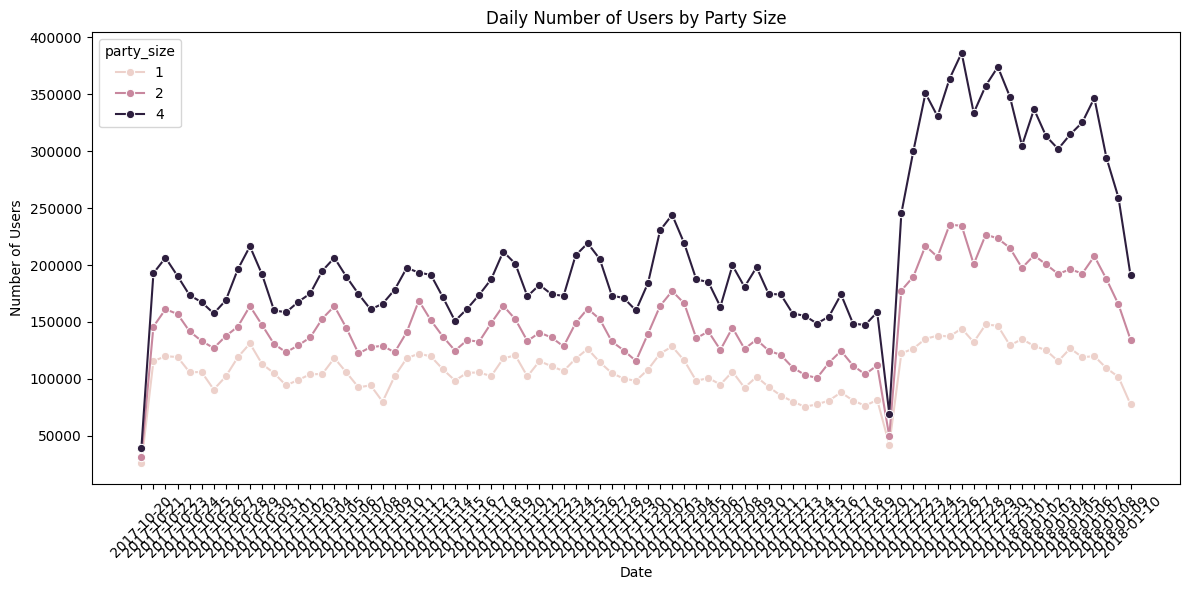

In [25]:
# 데이터 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=pdf, x="date_period", y="game_count", hue="party_size", marker="o")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Number of Users")
plt.title("Daily Number of Users by Party Size")
plt.tight_layout()
plt.show()

- 데이터의 범위는 2017년 10월 20일 ~ 2018년 1월 10일
- PUBG는 2017년 3월 24일 Steam에서 앞서 해보기로 선공개, 정식 출시일은 2017년 12월 21일
- 2017년 12월 20일 기준으로 매칭 데이터가 극소수로 존재하는데, 이는 정식 출시를 위한 대규모 패치 작업이 이루어진 것으로 확인
- 정식 출시 전과 후가 극명하게 갈리는 매치는 4인 파티(Squad), 2인 파티(Duo)이며, 솔로 플레이도 많이 증가하였으나 그 양이 현저히 미미한 것을 확인

In [26]:
del pdf

## **일별 솔로/듀오/스쿼드 별 평균 플레이 건수**

In [27]:
# 데이터 일자 변환
df_formatted = df.withColumn("date_period", date_format(col("date"), "yyyy-MM-dd"))

# 일별, 파티 사이즈별 유저 수 집계
df_daily = df_formatted.groupBy(["date_period", "party_size"]).agg(
    countDistinct("match_id").alias("game_count")).orderBy(["date_period", "party_size"])

# 데이터 확인
df_daily.limit(30).toPandas()

,date_period,party_size,game_count
0,2017-10-20,1,336
1,2017-10-20,2,441
2,2017-10-20,4,558
3,2017-10-21,1,1784
4,2017-10-21,2,2518
5,2017-10-21,4,3594
6,2017-10-22,1,2020
7,2017-10-22,2,3012
8,2017-10-22,4,4011
9,2017-10-23,1,2014


In [28]:
# pandas 데이터프레임으로 변환
pdf = df_daily.toPandas()

# 변환 확인
pdf.head(10)

,date_period,party_size,game_count
0,2017-10-20,1,336
1,2017-10-20,2,441
2,2017-10-20,4,558
3,2017-10-21,1,1784
4,2017-10-21,2,2518
5,2017-10-21,4,3594
6,2017-10-22,1,2020
7,2017-10-22,2,3012
8,2017-10-22,4,4011
9,2017-10-23,1,2014


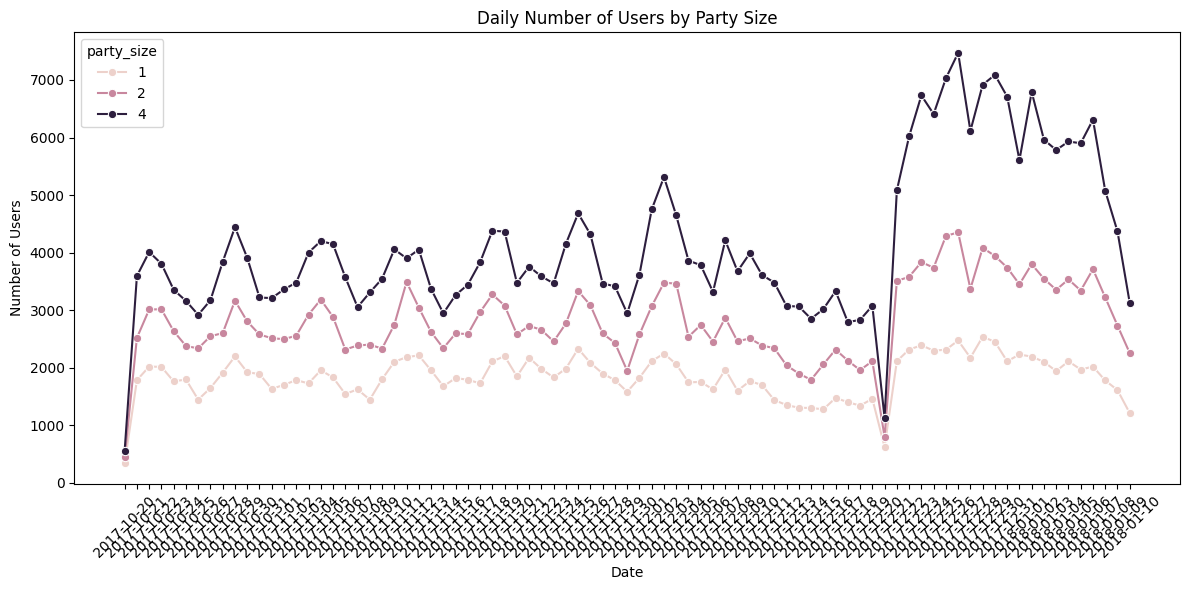

In [29]:
# 데이터 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=pdf, x="date_period", y="game_count", hue="party_size", marker="o")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Number of Users")
plt.title("Daily Number of Users by Party Size")
plt.tight_layout()
plt.show()

- 어쩌고
- 저쩌고
- 적을거
- 만든거

## **요일별 솔로/듀오/스쿼드 별 매칭 파티 건수**

In [38]:
# 데이터 일자 변환
df_formatted = df.withColumn("date_period", date_format(col("date"), "yyyy-MM-dd"))

# date_period를 day of week으로 변환
df_formatted = df_formatted.withColumn("day_of_week", date_format(col("date_period"), "E"))

# 요일별, 파티 사이즈별 유저 수 집계
df_weekly = df_formatted.groupBy(["day_of_week", "party_size"]).agg(
    countDistinct("match_id").alias("game_count")).orderBy(["day_of_week", "party_size"])

# 요일 순서 기준 컬럼 추가
df_weekly_ordered = df_weekly.withColumn(
    "day_order",
    when(col("day_of_week") == "Mon", 1)
    .when(col("day_of_week") == "Tue", 2)
    .when(col("day_of_week") == "Wed", 3)
    .when(col("day_of_week") == "Thu", 4)
    .when(col("day_of_week") == "Fri", 5)
    .when(col("day_of_week") == "Sat", 6)
    .when(col("day_of_week") == "Sun", 7)
)

# 월요일부터 일요일까지 순서대로 정렬
df_weekly_ordered = df_weekly_ordered.orderBy("day_order", "party_size")

# 결과 확인 (day_order 제거)
df_weekly_ordered.select("day_of_week", "party_size", "game_count").show(30, False)

+-----------+----------+----------+
|day_of_week|party_size|game_count|
+-----------+----------+----------+
|Mon        |1         |23731     |
|Mon        |2         |36286     |
|Mon        |4         |52736     |
|Tue        |1         |21532     |
|Tue        |2         |32977     |
|Tue        |4         |48811     |
|Wed        |1         |21034     |
|Wed        |2         |31820     |
|Wed        |4         |46025     |
|Thu        |1         |17634     |
|Thu        |2         |26302     |
|Thu        |4         |38787     |
|Fri        |1         |21043     |
|Fri        |2         |31279     |
|Fri        |4         |46273     |
|Sat        |1         |22964     |
|Sat        |2         |34964     |
|Sat        |4         |53928     |
|Sun        |1         |24800     |
|Sun        |2         |39045     |
|Sun        |4         |57998     |
+-----------+----------+----------+



In [39]:
# pandas 데이터프레임으로 변환
pdf = df_weekly_ordered.toPandas()

# 변환 확인
pdf.head(10)

,day_of_week,party_size,game_count,day_order
0,Mon,1,23731,1
1,Mon,2,36286,1
2,Mon,4,52736,1
3,Tue,1,21532,2
4,Tue,2,32977,2
5,Tue,4,48811,2
6,Wed,1,21034,3
7,Wed,2,31820,3
8,Wed,4,46025,3
9,Thu,1,17634,4


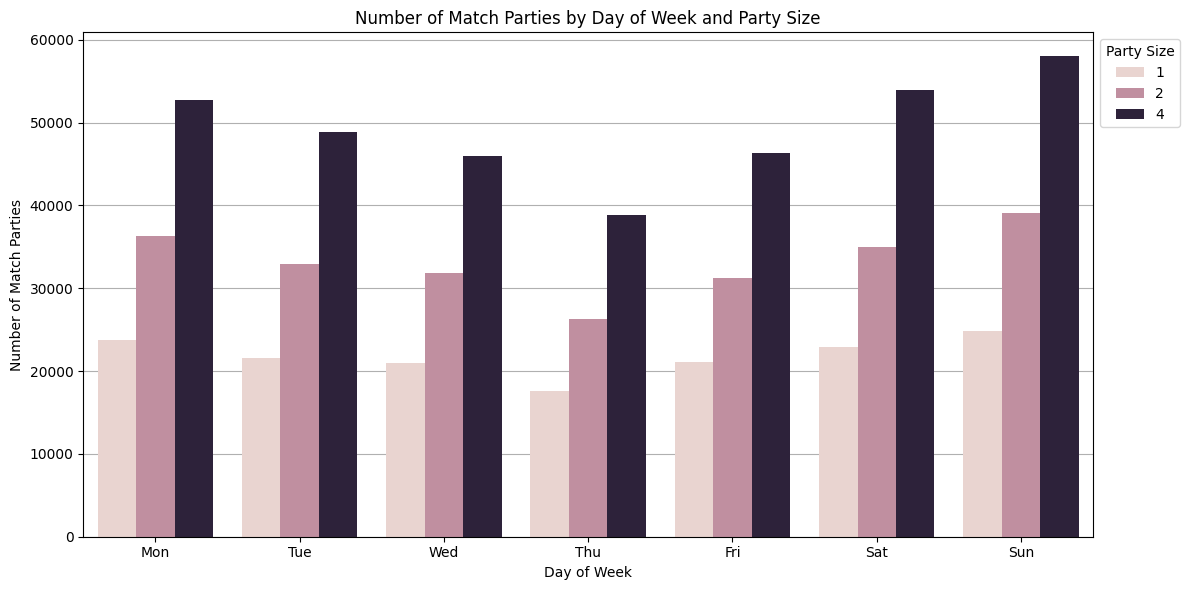

In [ ]:
# 데이터 시각화
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=pdf, x="day_of_week", y="game_count", hue="party_size")

plt.xlabel("Day of Week")
plt.ylabel("Number of Match Parties")
plt.title("Number of Match Parties by Day of Week and Party Size")

plt.legend(
    title="Party Size",
    bbox_to_anchor=(1, 1),   # (x, y) 위치
    loc="upper left"         # 앵커 기준점
)

ax.set_axisbelow(True)
plt.grid(axis="y")

plt.tight_layout()
plt.show()

# **심층 분석**

## **Early Access기간과 Official Launch기간 간 Day7 Retention Cohort 분석**

- Early Access 기준 : 2017년 10월 21일 ~ 2017년 10월 27일
- Official Launch 기준 : 2017년 12월 21일 ~ 2017년 12월 27일

### **유의사항**
- Official Launch는 출시일 기준부터 일주일이지만, Early Access 기준은 출시일 기준이 아닌 중간일 기준 계산

### **게임 업계의 Retention의 좋은 성과 기준**

Day 1 리텐션이 '좋은 성과'를 냈다고 말할 수 있는 기준은 **게임 장르, 플랫폼(모바일/PC), 유저 획득 경로(마케팅 채널), 게임의 서비스 단계(OBT/정식 출시)**에 따라 크게 달라짐

**Day 1 리텐션: '좋은 성과'의 기준**

- 해당 글([Game retention: 12 strategies from the most popular games](https://featureupvote.com/blog/game-retention))에 따르면, PC/콘솔 게임에서는 모바일보다 기대치가 높아서 Day 1 리텐션이 50~60% 이상이면 "좋은" 수준으로 보는 의견이 있음.
- 하지만 이건 게임 업계마다 다르기 때문에, 일반적으로 Day 1 Retention이 30% 이상일 경우, "**좋은 성과**를 낸 게임이다." 라고 이야기를 자주 한다고 함. (핵심 기준은 따로 없기 때문에 다양하게 살펴봐야하는 것이 핵심 문제)
    - [이와 관련한 게임 업계 내 리텐션 관련 블로그 글](https://gamedesigner-note.tistory.com/9)

**서비스 단계 내 고려 사항**

- Early Access: 정식 출시 전 최종 검증 단계이므로, 최소 35% 이상을 달성해야 정식 출시 시 성공 가능성이 높다고 판단할 수 있다.

In [31]:
# Cohort 분석 함수 정의
def create_cohort(df, title:str):
    # player_name 별 데이터 분리
    window_spec = Window.partitionBy("player_name")
    
    # 첫 플레이 일자 계산
    df = df.withColumn("first_play_date", min("date_period").over(window_spec))
    
    # 데이터 확인
    df.show(30)

    # CBT 기간 기준 Cohort 별 일자별 유저 수 집계
    df_cohort = df.groupBy(["first_play_date", "date_period"]).agg(
        countDistinct("player_name").alias("user_count")
    ).orderBy(["first_play_date", "date_period"])

    # pandas 데이터프레임으로 변환
    pdf_cohort = df_cohort.toPandas()
    
    # 변환 확인
    pdf_cohort.head(10)

    # date 컬럼을 datetime으로 변환
    pdf_cohort['first_play_date'] = pd.to_datetime(pdf_cohort['first_play_date'])
    pdf_cohort['date_period'] = pd.to_datetime(pdf_cohort['date_period'])
    
    # 첫 플레이일 기준 경과일 계산
    pdf_cohort['days_since_first_play'] = (pdf_cohort['date_period'] - pdf_cohort['first_play_date']).dt.days
    
    # 첫날 유저 수 (cohort size)
    cohort_size = pdf_cohort[pdf_cohort['days_since_first_play'] == 0][['first_play_date', 'user_count']]
    cohort_size = cohort_size.rename(columns={'user_count': 'cohort_size'})
    
    # 원본 데이터와 병합
    pdf_cohort = pdf_cohort.merge(cohort_size, on='first_play_date')

    # Retention 계산
    pdf_cohort['retention_rate'] = pdf_cohort['user_count'] / pdf_cohort['cohort_size']

    # first_play_date datetime 변환 (yyyy-mm-dd 형태로)
    pdf_cohort['first_play_date'] = pd.to_datetime(pdf_cohort['first_play_date']).dt.date

    # 행: first_play_date, 열: days_since_first_play, 값: retention_rate
    heatmap_data = pdf_cohort.pivot(index='first_play_date', 
                                   columns='days_since_first_play', 
                                   values='retention_rate')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel("Days Since First Play")
    plt.ylabel("Cohort First Play Date")
    plt.show()

### **Early Access 기간 데이터 EDA**

In [32]:
# Early Access 기간 데이터 필터링
df_early_accesss = df_formatted.filter(
    (col("date_period") >= "2017-10-21") & (col("date_period") <= "2017-10-27")
)

# 데이터 확인
df_early_accesss.show(30)

+-------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+--------------+-------------------+-------+--------------+-----------+-----------+
|               date|game_size|            match_id|match_mode|party_size|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|   player_name|player_survive_time|team_id|team_placement|date_period|day_of_week|
+-------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+--------------+-------------------+-------+--------------+-----------+-----------+
|2017-10-25 10:39:22|       27|2U4GBNA0YmmEUK5MT...|       tpp|         4|             0|          0|               0.0|        545.931152|         0|           0|    JarvanLING|             260.32|      1|            25| 2017-10-25|        Wed|
|2017-10-25 10:3

In [33]:
# Early Access 기간 참여 유저 수 집계
early_access_users = df_early_accesss.select("player_name").distinct().count()
print(f"Early Access  기간 참여 유저 수: {early_access_users}")

# Early Access 기간 매칭 파티 수 집계
early_access_match = df_early_accesss.select("match_id").distinct().count()
print(f"Early Access  기간 매칭 파티 수: {early_access_match}")

Early Access  기간 참여 유저 수: 1370551
Early Access  기간 매칭 파티 수: 54926


### **Early Access 기간 Cohort 분석**

+-------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+--------------+-------------------+-------+--------------+-----------+-----------+---------------+
|               date|game_size|            match_id|match_mode|party_size|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|   player_name|player_survive_time|team_id|team_placement|date_period|day_of_week|first_play_date|
+-------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+--------------+-------------------+-------+--------------+-----------+-----------+---------------+
|2017-10-26 07:30:00|       24|2U4GBNA0YmkHViRzU...|       tpp|         4|             0|          0| 5455.496999999999|         1314.7428|         0|           0|0---HaMMaN---0|            907.074|     30|        

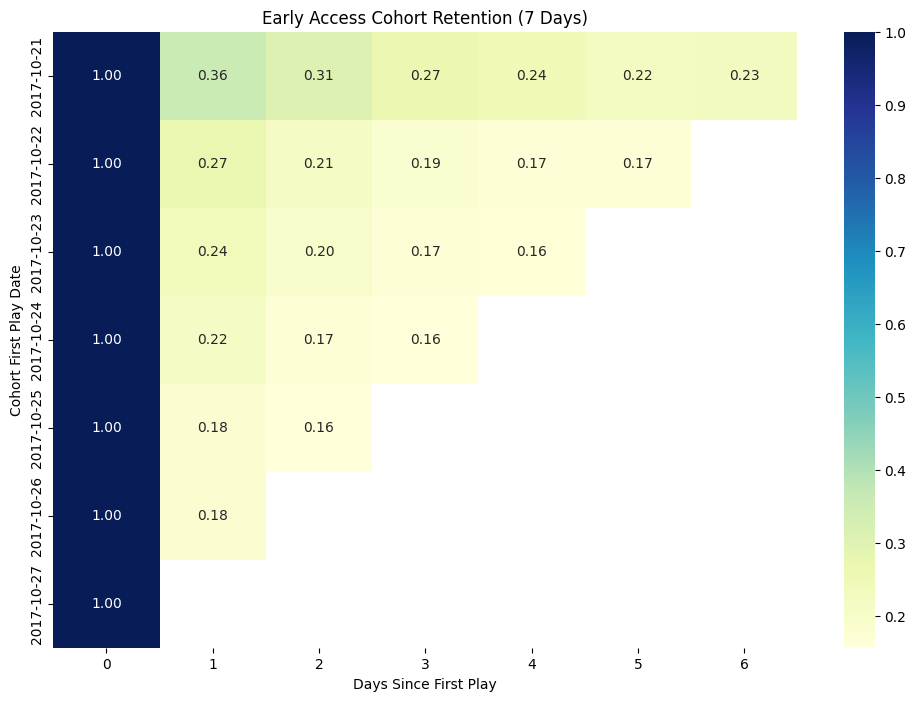

In [34]:
create_cohort(df_early_accesss, title="Early Access Cohort Retention (7 Days)")

해당 내용을 살펴보면 다음과 같이 정리할 수 있다.

### **Early Access 기간 내 Day 7 Retention Cohort 분석 결론**

#### **일반적인 게임 업계의 리텐션 지표**

- **Day 1 Retention (다음날 재접속률)** : 모바일 PC 온라인 게임 업계에서는 보통 30~40% 수준이면 준수한 편, 50% 이상이면 매우 우수한 편이다.
- **Day 7 Retention (일주일 후 재 접속률)** : 보통 10~20% 정도가 업계 평균치로 여겨짐. 20% 이상이면 상위권 게임으로 평가됨.
- **Day 30 Retention (30일 후 재접속률)** : 5~10%만 유지해도 성공적으로 안착했다고 봄.

#### **결과 해석**

- **Day 1 Retention (36%, 27%, 24%, 22% ...)**
    - 10월 21일 Cohort는 36%로 Early Access 환경에서도 매우 준수한 수치임.
    - 이후 Cohort에서 20%대로 하락한 것은 당시 서버 안정성 문제나 게임 밸런스 미완성 같은 Early Access 특성이 반영된 것으로 해석할 수 있음.
- **Day 3~7 Retention (약 16~23%)**
    - 대부분의 Cohort에서 7일차까지 15~23% 수준을 유지하고 있음. 이는 업계 평균을 상회하는 결과이며, 게임의 **초기 몰입도와 재미요소**가 강력하게 작동했음을 시사함.
- **Retention Curve의 패턴**
    - Day 1에서 급격히 이탈하지만 이후 1주일 내에는 일정 수준(15~20%)에서 안정화되었음. 이는 충성도 높은 Core 게이머 집단이 빠르게 남았음을 보여줌.

#### **게임 업계 관점에서의 의미**

**긍정적 요인**
- 출시 초기에 높은 관심과 입소문으로 Day 1 Retention이 평균 이상.
- 단순 반복 플레이가 아닌 "라운드 단위"의 독립적 경험. 중도 이탈 이후에도 복귀 여지가 큰 장르 특성.
- 초반 1주일 동안의 안정화된 Retention은 **장기 라이브 서비스 가능성**을 뒷받침함.

**우려 요인**
- 후반 Cohort의 Day 1 Retention이 20%대로 떨어진 점은, **서버 문제나 초기 피로감**이 반영되었을 가능성이 있음.
- Day Retention이 15%선에서 멈춘다는 것은, 결국 Core 유저층 이외의 라이트 유저는 빠르게 이탈했음을 보여줌.

### **결론 요약**

PUBG OBT의 리텐션은 당시 업계 평균 대비 상당히 높은 수준이며, "Day 7 기준 15~23% 유지"는 글로벌 흥행작으로 성장할 수 있는 핵심 지표이다. 다만, Cohort별 Day 1 차이가 발생하는 것은 서비스 안정화 및 신규 유저 온보딩에서 개선 과제가 있었음을 의미한다.

## **Early Access기간과 Official Launch기간 간 Day7 Retention Cohort 분석**

- Early Access 기준 : 2017년 10월 21일 ~ 2017년 10월 27일
- Official Launch 기준 : 2017년 12월 21일 ~ 2017년 12월 27일

### **유의사항**
- Official Launch는 출시일 기준부터 일주일이지만, Early Access 기준은 출시일 기준이 아닌 중간일 기준 계산

### **게임 업계의 Retention의 좋은 성과 기준**

Day 1 리텐션이 '좋은 성과'를 냈다고 말할 수 있는 기준은 **게임 장르, 플랫폼(모바일/PC), 유저 획득 경로(마케팅 채널), 게임의 서비스 단계(OBT/정식 출시)**에 따라 크게 달라짐

**Day 1 리텐션: '좋은 성과'의 기준**

- 해당 글([Game retention: 12 strategies from the most popular games](https://featureupvote.com/blog/game-retention))에 따르면, PC/콘솔 게임에서는 모바일보다 기대치가 높아서 Day 1 리텐션이 50~60% 이상이면 "좋은" 수준으로 보는 의견이 있음.
- 하지만 이건 게임 업계마다 다르기 때문에, 일반적으로 Day 1 Retention이 30% 이상일 경우, "**좋은 성과**를 낸 게임이다." 라고 이야기를 자주 한다고 함. (핵심 기준은 따로 없기 때문에 다양하게 살펴봐야하는 것이 핵심 문제)
    - [이와 관련한 게임 업계 내 리텐션 관련 블로그 글](https://gamedesigner-note.tistory.com/9)

**서비스 단계 내 고려 사항**

- Early Access: 정식 출시 전 최종 검증 단계이므로, 최소 35% 이상을 달성해야 정식 출시 시 성공 가능성이 높다고 판단할 수 있다.